# Variational quantum algorithms for trace norms and their applications

这是一篇使用量子变分方法求解Hermite矩阵迹范数的文章，Hermite矩阵（下文用H表示）的迹范数定义如下：
$$\Vert H\Vert _{tr}=\Sigma ^n _{i=1} \vert \lambda _i \vert$$
非Hermite矩阵可以求如下Hermite矩阵的迹范数：
$$\overline{A}=\begin{pmatrix}
    0 & A \\
    A^\dagger & 0
    \end{pmatrix}
$$
有关系$\Vert \overline{A} \Vert _{tr}=2\Vert A \Vert _{tr}$
文中举出了三种方法来计算矩阵的迹范数，分别进行介绍。作为文中运行的例子，我们首先引入相关库：

In [1]:
import numpy as np
from mindquantum.core.circuit import Circuit
from mindquantum.core.gates import RY,RZ,CNOT,H,X,Z,Measure,UnivMathGate
import mindspore as ms                                         # 导入mindspore库并简写为ms
from mindquantum.framework import MQAnsatzOnlyLayer            # 导入MQLayer
from mindquantum.simulator import Simulator
from mindquantum.core.operators import QubitOperator           # 导入QubitOperator模块，用于构造泡利算符
from mindquantum.core.operators import Hamiltonian             # 导入Hamiltonian模块，用于构建哈密顿量
import matplotlib.pyplot as plt

然后定义文中使用的矩阵:
$$H=8I_2 \otimes I_2+2\sigma _x \otimes \sigma _z+6\sigma _z \otimes \sigma _x$$
即为
$$\begin{pmatrix}
8&6&2&0\\
6&8&0&-2\\
2&0&8&-6\\
0&-2&-6&8
\end{pmatrix}$$
这种形式还将在后续用到，所以暂时不做化简。
文中使用如下形式表示矩阵的迹范数：
$$\Vert A \Vert _{tr}=\max \limits _U \vert tr(UA) \vert =\frac{1}{2} \max \limits _U (tr(AU)+tr(A ^\dagger U ^\dagger))$$
等价性的证明可见论文。
所以，我们需要找到使得$l_1(\mathbf{\theta})=\frac{1}{2} (tr(AU(\mathbf{\theta}))+tr(A ^\dagger U(\mathbf{\theta}) ^\dagger))$最小的参数$\mathbf{\theta}$，其中$\mathbf{\theta}=(\theta _1,\theta _2, \cdots, \theta _m)$，参数化酉矩阵$U(\mathbf{\theta})$由单比特旋转门和CNOT门组合而成，如下所示：
$$U(\mathbf{\theta})=\prod \limits _{j=1} ^m e^{-i\theta _j H _j}$$
$H_j$是Pauli矩阵的张量积。
对于文中的例子，最多用到是二比特的参数化酉矩阵，可以用如下方式进行设置：

In [2]:
example1=Circuit()
example1+=RZ('theta1').on(0)
example1+=RY('theta2').on(1)
example1+=CNOT.on(1,ctrl_qubits=0)
example1+=RY('theta3').on(1)
example1+=CNOT.on(0,ctrl_qubits=1)
example1.svg()

## 方法一
该方法需要先对H矩阵分解成一系列密度矩阵的叠加，但以上形式并不是密度矩阵的叠加，所以我们将H化为密度矩阵叠加的形式：
$$
H=4\begin{pmatrix}
\frac{1}{4}&-\frac{1}{4}&\frac{1}{4}&\frac{1}{4}\\
-\frac{1}{4}&\frac{1}{4}&-\frac{1}{4}&-\frac{1}{4}\\
\frac{1}{4}&-\frac{1}{4}&\frac{1}{4}&\frac{1}{4}\\
\frac{1}{4}&-\frac{1}{4}&\frac{1}{4}&\frac{1}{4}
\end{pmatrix}+12\begin{pmatrix}
\frac{1}{4}&\frac{1}{4}&-\frac{1}{4}&\frac{1}{4}\\
\frac{1}{4}&\frac{1}{4}&-\frac{1}{4}&\frac{1}{4}\\
-\frac{1}{4}&-\frac{1}{4}&\frac{1}{4}&-\frac{1}{4}\\
\frac{1}{4}&\frac{1}{4}&-\frac{1}{4}&\frac{1}{4}
\end{pmatrix}+16\begin{pmatrix}
\frac{1}{4}&\frac{1}{4}&\frac{1}{4}&-\frac{1}{4}\\
\frac{1}{4}&\frac{1}{4}&\frac{1}{4}&-\frac{1}{4}\\
\frac{1}{4}&\frac{1}{4}&\frac{1}{4}&-\frac{1}{4}\\
-\frac{1}{4}&-\frac{1}{4}&-\frac{1}{4}&\frac{1}{4}
\end{pmatrix}$$

$$=4\begin{pmatrix}
\frac{1}{2}\\
-\frac{1}{2}\\
\frac{1}{2}\\
\frac{1}{2}
\end{pmatrix}\begin{pmatrix}
\frac{1}{2}&-\frac{1}{2}&\frac{1}{2}&\frac{1}{2}
\end{pmatrix}+12\begin{pmatrix}
\frac{1}{2}\\
\frac{1}{2}\\
-\frac{1}{2}\\
\frac{1}{2}
\end{pmatrix}\begin{pmatrix}
\frac{1}{2}&\frac{1}{2}&-\frac{1}{2}&\frac{1}{2}
\end{pmatrix}+16\begin{pmatrix}
\frac{1}{2}\\
\frac{1}{2}\\
\frac{1}{2}\\
-\frac{1}{2}
\end{pmatrix}\begin{pmatrix}
\frac{1}{2}&\frac{1}{2}&\frac{1}{2}&-\frac{1}{2}
\end{pmatrix}$$
后面的密度矩阵都是纯态，可以通过对初始向量做酉变换得到。对三个密度矩阵使用相同的参数组成电路，再把三个损失函数线性组合得到最终的损失函数。

损失函数可以通过量子电路计算。方法如下：将已知量子态和一个控制比特放在一个系统，先对控制比特作用一个H门，再对量子态作用已知酉变换，但加上控制比特；再对控制比特作用一个H门，再用Z门测量控制比特。期望值即为所求损失函数。下图为所示电路。

In [3]:
example2=Circuit()
example2+=H.on(0)
example2+=UnivMathGate('U',np.identity(4)).on([1,2],0)
example2+=H.on(0)
example2+=Measure().on(0)
example2.svg()

受控酉门可以通过对酉门的每一个门加上控制比特实现。

在论文的附录里，也对如何求解函数的导数做出了说明。由于mindquantum内置了求解导数的方法，所以我们直接利用该方法进行求解，后续会说明论文中使用的求解导数方法。

完整代码如下：

In [4]:
def get_grad_method1(gates):        #首先将重复的电路构造做成一个函数，态初始化部分作为输入变量插入电路
    circuit=Circuit()
    for gate in gates:
        circuit+=gate
            
    circuit+=H.on(0)
    circuit+=RZ('theta1').on(1,0)
    circuit+=RY('theta2').on(2,0)
    circuit+=X.on(2,[0,1])      #控制X门可以充当CNOT门
    circuit+=RY('theta3').on(2,0)
    circuit+=X.on(1,[0,2])
    circuit+=H.on(0)

    #hamilton量定义
    hams = [Hamiltonian(QubitOperator('Z0'))]
    #模拟模块加载
    sim = Simulator('mqvector', circuit.n_qubits)

    grad_ops = sim.get_expectation_with_grad(hams,circuit)
    return (circuit,grad_ops)

In [5]:
grad1=get_grad_method1([H.on(1),H.on(2),X.on(1),Z.on(2,1),X.on(1)])
grad2=get_grad_method1([H.on(1),H.on(2),X.on(2,1),Z.on(2,1),X.on(2,1)])
grad3=get_grad_method1([H.on(1),H.on(2),Z.on(2,1)])

learning_rate=0.1
iter=70
np.random.seed(0)
#由于有三个网络，所以无法直接使用框架进行求解，但上面已经得到梯度，因此可以直接写一个程序进行求解
#初始化参数
theta1=np.random.rand(3)*2*np.pi
result1=[]
for i in range(iter):
    f1,g1=grad1[1](theta1)
    f2,g2=grad2[1](theta1)
    f3,g3=grad3[1](theta1)
    expectation1=4*f1+12*f2+16*f3
    gradient1=4*g1+12*g2+16*g3
    theta1+=learning_rate*gradient1.real[0][0]        #梯度下降应该只有实数
    result1.append(expectation1[0][0].real)
np.random.seed(None)

In [6]:
grad1[0].svg()

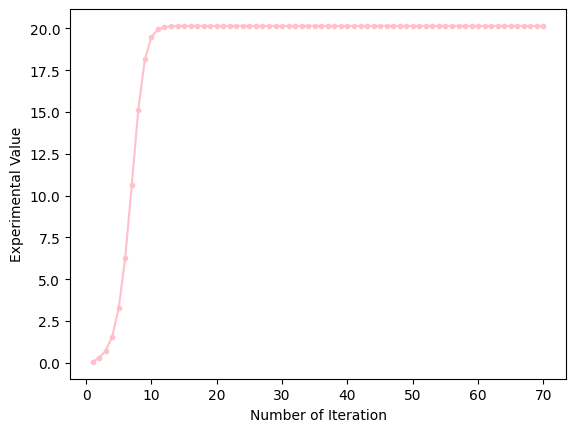

In [7]:
plt.xlabel('Number of Iteration')
plt.ylabel('Experimental Value')
plt.plot(list(range(1,iter+1)),result1,'.-',color='pink')

由上图可以看出，结果并没有逼近矩阵的迹范数32，分析原因是因为对酉矩阵的参数化不够彻底，因此我们使用下文中的电路

In [8]:
def get_grad_method2(gates):        #首先将重复的电路构造做成一个函数，态初始化部分作为输入变量插入电路
    circuit=Circuit()
    for gate in gates:
        circuit+=gate
            
    circuit+=H.on(0)
    circuit+=RZ('theta1').on(1,0)
    circuit+=RY('theta2').on(2,0)
    circuit+=X.on(2,[0,1])
    circuit+=RZ('theta3').on(1,0)
    circuit+=RY('theta4').on(2,0)
    circuit+=X.on(1,[0,2])
    circuit+=RZ('theta5').on(1,0)
    circuit+=RY('theta6').on(2,0)
    circuit+=X.on(2,[0,1])
    circuit+=RZ('theta7').on(1,0)
    circuit+=RY('theta8').on(2,0)
    circuit+=X.on(1,[0,2])
    circuit+=H.on(0)

    #hamilton量定义
    hams = [Hamiltonian(QubitOperator('Z0'))]
    #模拟模块加载
    sim = Simulator('mqvector', circuit.n_qubits)

    grad_ops = sim.get_expectation_with_grad(hams,circuit)
    return (circuit,grad_ops)

In [9]:
grad4=get_grad_method2([H.on(1),H.on(2),X.on(1),Z.on(2,1),X.on(1)])
grad5=get_grad_method2([H.on(1),H.on(2),X.on(2,1),Z.on(2,1),X.on(2,1)])
grad6=get_grad_method2([H.on(1),H.on(2),Z.on(2,1)])

learning_rate=0.1
iter=70
np.random.seed(0)
#由于有三个网络，所以无法直接使用框架进行求解，但上面已经得到梯度，因此可以直接写一个程序进行求解
#初始化参数
theta2=np.random.rand(8)*2*np.pi
result2=[]
for i in range(iter):
    f4,g4=grad4[1](theta2)
    f5,g5=grad5[1](theta2)
    f6,g6=grad6[1](theta2)
    expectation2=4*f4+12*f5+16*f6
    gradient2=4*g4+12*g5+16*g6
    theta2+=learning_rate*gradient2.real[0][0]        #梯度下降应该只有实数
    result2.append(expectation2[0][0].real)
np.random.seed(None)

In [10]:
grad4[0].svg()

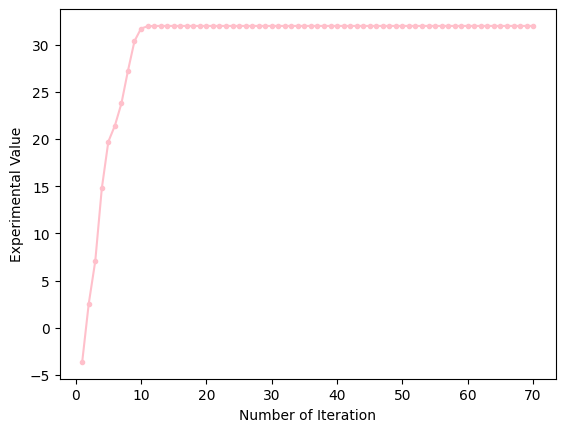

In [11]:
plt.xlabel('Number of Iteration')
plt.ylabel('Experimental Value')
plt.plot(list(range(1,iter+1)),result2,'.-',color='pink')

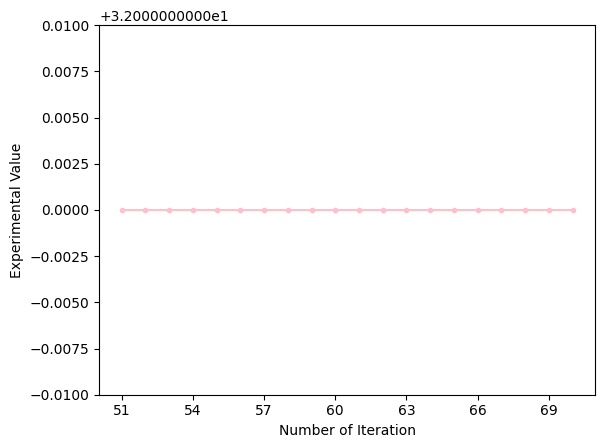

In [20]:
plt.xticks(range(51,iter+1,3))
plt.ylim([31.99,32.01])
plt.xlabel('Number of Iteration')
plt.ylabel('Experimental Value')
plt.plot(list(range(51,iter+1)),result2[50:],'.-',color='pink')

可以发现迹已经很好的逼近了32。方法一是有效的，但是要将目标矩阵化为密度矩阵的叠加是一个问题。

## 方法二
这种方法文中没有特别具体的说明，在后面的数值实验中也没有进行数值实验，因此这里简要介绍一下，不再使用。
这种方法仍然使用方法一的分解方法，分解成如下两个部分：
$$\rho_+=\frac{\alpha I+H}{tr(\alpha I+H)},\rho_-=\frac{\alpha I-H}{tr(\alpha I-H)}$$
可以取$\alpha=\Sigma _i \vert h_{ii} \vert$，保证两个都是密度矩阵。然后优化函数$l_2(\mathbf{\theta})=tr(\alpha I+H)f_+(\mathbf{\theta})-tr(\alpha I-H)f_-(\mathbf{\theta})$，其中$f_\pm(\mathbf{\theta})=\frac{1}{4}(tr(\rho_\pm U(\mathbf{\theta}))+tr(\rho_\pm U(\mathbf{\theta})))$。
文中介绍了一种生成$\vert I \rangle$的电路，在下面展示（以两粒子为例，更多粒子可类推），方法三中会使用。

In [13]:
example3=Circuit()
example3+=H.on(0)
example3+=H.on(1)
example3+=X.on(2,0)
example3+=X.on(3,1)
example3.svg()

前两个通道的粒子即为目标态。

## 方法三
该方法需要先对H矩阵分解成一系列酉矩阵的叠加，这个有现成的形式。
这类估计的方法是对每一个酉矩阵计算其与含参酉矩阵乘积的迹，再进行线性叠加得到损失函数，因此通过优化参数得到迹范数。
注意到，两粒子$\vert I \rangle$的密度矩阵是$\frac{1}{4}I$，因此目标函数结果还需要再乘以一个4。
具体代码如下所示：

In [14]:
def get_grad_method3(gates):        #首先将重复的电路构造做成一个函数，态初始化部分作为输入变量插入电路
    circuit=Circuit()
    for gate in gates:
        circuit+=gate
            
    circuit+=H.on(0)
    circuit+=RZ('theta1').on(1,0)
    circuit+=RY('theta2').on(2,0)
    circuit+=X.on(2,[0,1])      #控制X门可以充当CNOT门
    circuit+=RY('theta3').on(2,0)
    circuit+=X.on(1,[0,2])
    circuit+=H.on(0)

    #hamilton量定义
    hams = [Hamiltonian(QubitOperator('Z0'))]
    #模拟模块加载
    sim = Simulator('mqvector', circuit.n_qubits)

    grad_ops = sim.get_expectation_with_grad(hams,circuit)
    return (circuit,grad_ops)

In [15]:
grad7=get_grad_method3([H.on(1),X.on(3,1),H.on(2),X.on(4,2)])
grad8=get_grad_method3([H.on(1),X.on(3,1),H.on(2),X.on(4,2),X.on(1),Z.on(2)])
grad9=get_grad_method3([H.on(1),X.on(3,1),H.on(2),X.on(4,2),Z.on(1),X.on(2)])
learning_rate=0.1
iter=70

np.random.seed(0)
theta3=np.random.rand(3)*2*np.pi
result3=[]
for i in range(iter):
    f7,g7=grad7[1](theta3)
    f8,g8=grad8[1](theta3)
    f9,g9=grad9[1](theta3)
    expectation3=(8*f7+2*f8+6*f9)*4
    gradient3=(8*g7+2*g8+6*g9)
    theta3+=learning_rate*gradient3.real[0][0]        #梯度下降应该只有实数
    result3.append(expectation3[0][0].real)
np.random.seed(None)

In [16]:
grad7[0].svg()

结果作图，如下图所示

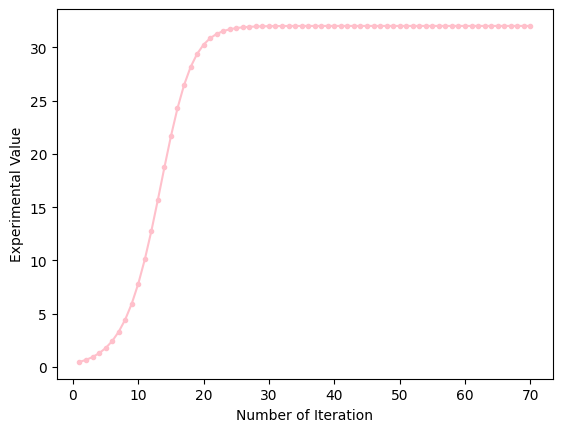

In [17]:
plt.xlabel('Number of Iteration')
plt.ylabel('Experimental Value')
plt.plot(list(range(1,iter+1)),result3,'.-',color='pink')

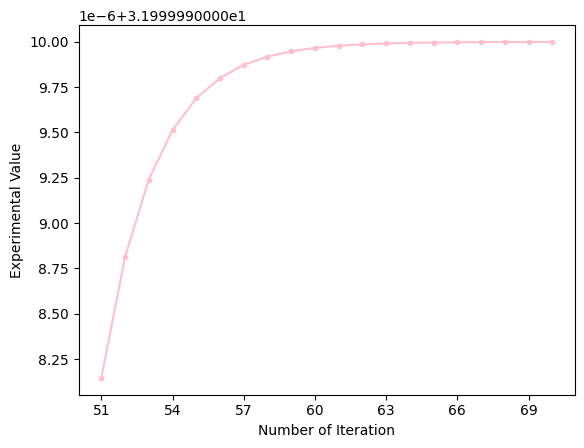

In [18]:
plt.xticks(range(51,iter+1,3))
plt.xlabel('Number of Iteration')
plt.ylabel('Experimental Value')
plt.plot(list(range(51,iter+1)),result3[50:],'.-',color='pink',)

从图中可以观察到，当迭代次数在10次左右时就已经稳定在32左右了，而原矩阵的迹范数正好是32，由此可以说明该方法的确能正确逼近矩阵的迹范数。

再展现一下最优参数

In [19]:
example4=Circuit()
example4+=RZ(str(theta3[0])).on(0)
example4+=RY(str(theta3[1])).on(1)
example4+=X.on(1,0)
example4+=RY(str(theta3[2])).on(1)
example4+=X.on(0,1)
example4.svg()

## 附录
最后介绍一下文中的求解含参酉矩阵的方法。这里只展现公式，证明请参见文章附录。取

$$l_1(\mathbf{\theta})=\frac{1}{2} \max \limits _U (tr(\rho U(\mathbf{\theta}))+tr(\rho ^\dagger U ^\dagger(\mathbf{\theta})))$$

$$\rho=\sum \limits ^d_{i=1} r_i \rho _i$$

$$U(\mathbf{\theta})=\prod \limits _{j=1} ^m e^{-i\theta _j H _j}$$

$$\mathbf{\theta}=(\theta _1,\theta _2, \cdots, \theta _m)$$

则有

$$\frac{\partial l_1}{\partial \theta _j} = \frac{1}{4} \sum \limits ^d_{i=1} r_i (tr(\rho _i U ({\theta}_{+j} ) )+tr(U ^\dagger ({\theta}_{+j}) \rho _i))$$

其中 $\mathbf{\theta}_{+j}=(\theta _1,\cdots,\theta _j + \pi, \cdots, \theta _m)$